<a href="https://colab.research.google.com/github/mahdieslaminet/Skin-Cancer-Classification-Vision-Transformers/blob/jupiter-implementation/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# پروژه تشخیص سرطان پوست با دیتاست HAM10000

**مدل:** ResNet18 سبک‌شده  
**دیتاست:** HAM10000 (10015 تصویر)  
**محیط:** Google Colab + Google Drive  

این نوت‌بوک شامل:
- اتصال به درایو و بارگذاری دیتاست
- تحلیل اکتشافی داده‌ها (EDA)
- آموزش مدل سبک (۱۰ اپوک روی ۲۰٪ داده برای سرعت)
- ارزیابی و پیش‌بینی روی تصویر نمونه

In [1]:

from google.colab import drive
drive.mount('/content/drive')

# مسیر اصلی دیتاست در درایوت رو چک کن (اگر مسیر متفاوته، اصلاح کن)
dataset_path = '/content/drive/MyDrive/HAM10000_dataset'  # 👈 اگر اسم پوشه‌ت فرق داره، اینجا تغییر بده

import os
print("محتویات پوشه دیتاست:")
print(os.listdir(dataset_path))

Mounted at /content/drive
محتویات پوشه دیتاست:
['HAM10000_metadata.csv', 'HAM10000_images_part_1', 'HAM10000_images_part_2 (1)']


In [2]:
!pip install -q torch torchvision albumentations tqdm

print("کتابخانه‌ها نصب شدند!")

کتابخانه‌ها نصب شدند!


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import pandas as pd
import os

# مسیرها (از قبل تعریف شده)
# images_part1, images_part2, metadata_path

class_mapping = {
    'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3,
    'mel': 4, 'nv': 5, 'vasc': 6
}

class HAM10000Dataset(Dataset):
    def __init__(self, df, img_dir1, img_dir2, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transform = transform

        # پیش‌بارگذاری لیست فایل‌های موجود در هر دو پوشه (بدون توجه به بزرگ/کوچک بودن)
        print("در حال جمع‌آوری لیست فایل‌های موجود در پوشه‌ها...")
        self.available_files = set()

        for directory in [img_dir1, img_dir2]:
            if os.path.exists(directory):
                for f in os.listdir(directory):
                    if f.lower().endswith('.jpg'):
                        self.available_files.add(f.lower())  # همه رو به حروف کوچک تبدیل می‌کنیم
            else:
                print(f"هشدار: پوشه وجود ندارد → {directory}")

        print(f"تعداد فایل‌های JPG پیدا شده: {len(self.available_files)}")

        # فیلتر کردن فقط نمونه‌هایی که تصویرشون واقعاً وجود داره
        self.valid_indices = []
        missing_images = []

        for idx in range(len(self.df)):
            img_id = self.df.iloc[idx]['image_id']
            filename_lower = f"{img_id.lower()}.jpg"

            if filename_lower in self.available_files:
                self.valid_indices.append(idx)
            else:
                missing_images.append(img_id)
                if len(missing_images) <= 10:  # فقط ۱۰ تا اول رو نشون بده
                    print(f"تصویر گم‌شده: {img_id}.jpg")

        if missing_images:
            print(f"تعداد کل تصاویر گم‌شده: {len(missing_images)}")
            if len(missing_images) > 10:
                print("... (فقط ۱۰ تای اول نمایش داده شد)")

        print(f"تعداد نمونه‌های معتبر نهایی: {len(self.valid_indices)} از {len(self.df)}")

        if len(self.valid_indices) == 0:
            raise ValueError("هیچ تصویر معتبری پیدا نشد! مسیرها یا نام فایل‌ها رو چک کن.")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        row = self.df.iloc[real_idx]
        img_id = row['image_id']
        label = class_mapping[row['dx']]

        # جستجوی فایل بدون توجه به بزرگ/کوچک بودن
        target_filename = f"{img_id}.jpg"
        found_path = None

        for directory in [self.img_dir1, self.img_dir2]:
            if not os.path.exists(directory):
                continue
            for f in os.listdir(directory):
                if f.lower() == target_filename.lower():
                    found_path = os.path.join(directory, f)
                    break
            if found_path:
                break

        if found_path is None:
            raise FileNotFoundError(f"Image {target_filename} not found (even after case-insensitive search)!")

        image = Image.open(found_path).convert('RGB')
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

print("✅ کلاس دیتاست جدید با پشتیبانی از نام فایل با حروف بزرگ/کوچک آماده است!")

✅ کلاس دیتاست جدید با پشتیبانی از نام فایل با حروف بزرگ/کوچک آماده است!


تعداد کل نمونه‌ها: 10015
ستون‌ها: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

توزیع کلاس‌ها:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


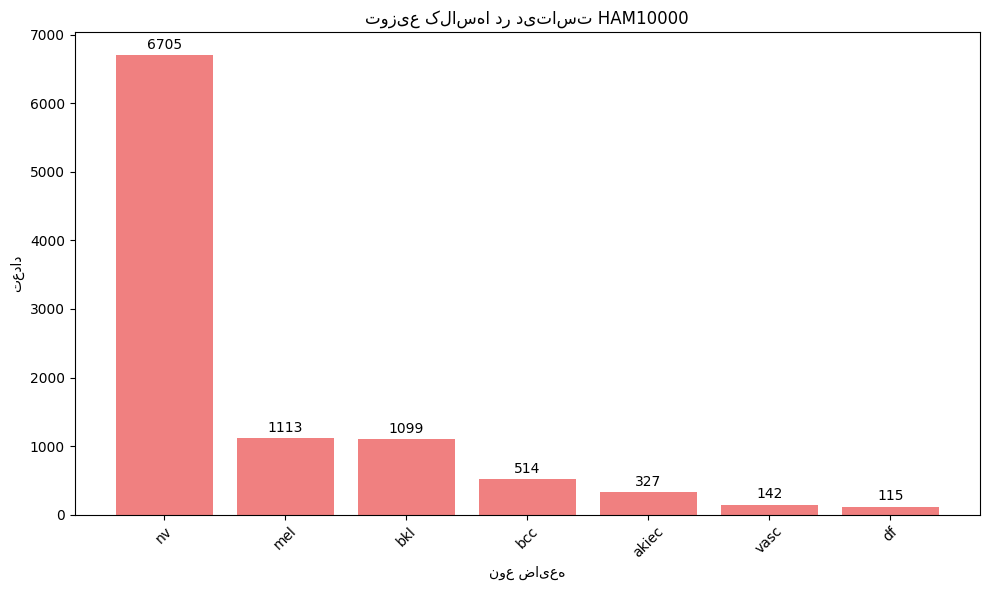


میانگین سن: 51.9 سال
توزیع جنسیت:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

۱۰ مکان شایع:
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
Name: count, dtype: int64


In [10]:
import matplotlib.pyplot as plt

# بارگذاری metadata
metadata_df = pd.read_csv(metadata_path)

print(f"تعداد کل نمونه‌ها: {len(metadata_df)}")
print(f"ستون‌ها: {list(metadata_df.columns)}\n")

print("توزیع کلاس‌ها:")
class_counts = metadata_df['dx'].value_counts()
print(class_counts)

# نمودار توزیع کلاس‌ها
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='lightcoral')
plt.xlabel('نوع ضایعه')
plt.ylabel('تعداد')
plt.title('توزیع کلاس‌ها در دیتاست HAM10000')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nمیانگین سن: {metadata_df['age'].mean():.1f} سال")
print(f"توزیع جنسیت:\n{metadata_df['sex'].value_counts()}")
print(f"\n۱۰ مکان شایع:\n{metadata_df['localization'].value_counts().head(10)}")

In [11]:
from sklearn.model_selection import train_test_split

# استفاده از ۲۰٪ داده برای آموزش سریع (یا اگر می‌خوای کامل، frac=1 بذار)
frac = 0.2  # تغییر بده به 1.0 اگر می‌خوای کل دیتاست رو استفاده کنی
small_df = metadata_df.sample(frac=frac, random_state=42).reset_index(drop=True)

train_df, temp_df = train_test_split(small_df, test_size=0.3, stratify=small_df['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

print(f"تقسیم داده‌ها:")
print(f"  آموزشی: {len(train_df)} نمونه")
print(f"  اعتبارسنجی: {len(val_df)} نمونه")
print(f"  تست: {len(test_df)} نمونه\n")

# تحولات تصویر
transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("در حال ساخت دیتاست‌ها و چک کردن وجود تصاویر...")

# ساخت دیتاست‌ها (اینجا چک انجام می‌شه)
try:
    train_dataset = HAM10000Dataset(train_df, images_part1, images_part2, transform=transform)
    val_dataset = HAM10000Dataset(val_df, images_part1, images_part2, transform=transform)
    test_dataset = HAM10000Dataset(test_df, images_part1, images_part2, transform=transform)
except ValueError as e:
    print("❌ خطا در ساخت دیتاست:")
    print(e)
    print("\n💡 راه‌حل‌های احتمالی:")
    print("1. مسیر dataset_path رو دوباره چک کن (سلول ۲)")
    print("2. مطمئن شو پوشه‌ها دقیقاً این نام‌ها رو دارن:")
    print(f"   {images_part1}")
    print(f"   {images_part2}")
    print("3. چند نمونه image_id از metadata:")
    print(metadata_df['image_id'].head(10).tolist())
    print("4. چند فایل واقعی در پوشه part1:")
    print(os.listdir(images_part1)[:10] if os.path.exists(images_part1) else "پوشه وجود ندارد!")
    raise  # متوقف می‌شه تا مشکل رو حل کنی

# چک نهایی تعداد نمونه‌های معتبر
print(f"\nتعداد نمونه‌های معتبر بعد از فیلتر تصاویر گم‌شده:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val:   {len(val_dataset)}")
print(f"  Test:  {len(test_dataset)}")

if len(train_dataset) == 0 or len(val_dataset) == 0 or len(test_dataset) == 0:
    print("❌ حداقل یکی از دیتاست‌ها خالیه! نمی‌تونیم آموزش رو شروع کنیم.")
    print("احتمالاً اکثر تصاویر پیدا نشدن. مسیرها رو دوباره چک کن.")
else:
    print("✅ همه دیتاست‌ها آماده‌اند!")

    # دیتالودرها (batch_size کوچک برای سرعت و حافظه)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

    print("دیتالودرها با موفقیت ساخته شدند. حالا می‌تونی آموزش رو شروع کنی!")

تقسیم داده‌ها:
  آموزشی: 1402 نمونه
  اعتبارسنجی: 300 نمونه
  تست: 301 نمونه

در حال ساخت دیتاست‌ها و چک کردن وجود تصاویر...
در حال جمع‌آوری لیست فایل‌های موجود در پوشه‌ها...
هشدار: پوشه وجود ندارد → /content/drive/MyDrive/HAM10000_dataset/HAM10000_images_part_2
تعداد فایل‌های JPG پیدا شده: 5002
تصویر گم‌شده: ISIC_0029900.jpg
تصویر گم‌شده: ISIC_0031764.jpg
تصویر گم‌شده: ISIC_0029628.jpg
تصویر گم‌شده: ISIC_0030440.jpg
تصویر گم‌شده: ISIC_0032385.jpg
تصویر گم‌شده: ISIC_0032566.jpg
تصویر گم‌شده: ISIC_0032965.jpg
تصویر گم‌شده: ISIC_0033564.jpg
تصویر گم‌شده: ISIC_0029802.jpg
تصویر گم‌شده: ISIC_0029461.jpg
تعداد کل تصاویر گم‌شده: 690
... (فقط ۱۰ تای اول نمایش داده شد)
تعداد نمونه‌های معتبر نهایی: 712 از 1402
در حال جمع‌آوری لیست فایل‌های موجود در پوشه‌ها...
هشدار: پوشه وجود ندارد → /content/drive/MyDrive/HAM10000_dataset/HAM10000_images_part_2
تعداد فایل‌های JPG پیدا شده: 5002
تصویر گم‌شده: ISIC_0030745.jpg
تصویر گم‌شده: ISIC_0032612.jpg
تصویر گم‌شده: ISIC_0033744.jpg
تصویر گم‌شده: ISIC_00311

In [12]:
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

class LightweightResNet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        # فریز لایه‌های اولیه
        for param in list(self.backbone.parameters())[:-10]:
            param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"دستگاه: {device}")

model = LightweightResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("شروع آموزش (۱۰ اپوک)...")
best_val_acc = 0

for epoch in range(10):
    model.train()
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/10 - Train'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_acc = 100. * train_correct / train_total

    # اعتبارسنجی
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/HAM10000_dataset/best_model.pth')
        print("  → مدل بهتر ذخیره شد!")

print(f"\nبهترین دقت اعتبارسنجی: {best_val_acc:.2f}%")

دستگاه: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


شروع آموزش (۱۰ اپوک)...


Epoch 1/10 - Train:   0%|          | 0/89 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/10 - Train: 100%|██████████| 89/89 [09:02<00:00,  6.09s/it]


Epoch 1 | Train Acc: 70.08% | Val Acc: 77.27%
  → مدل بهتر ذخیره شد!


Epoch 2/10 - Train: 100%|██████████| 89/89 [07:11<00:00,  4.85s/it]


Epoch 2 | Train Acc: 72.61% | Val Acc: 75.00%


Epoch 3/10 - Train: 100%|██████████| 89/89 [07:01<00:00,  4.73s/it]


Epoch 3 | Train Acc: 75.00% | Val Acc: 71.97%


Epoch 4/10 - Train: 100%|██████████| 89/89 [06:32<00:00,  4.41s/it]


Epoch 4 | Train Acc: 76.83% | Val Acc: 75.00%


Epoch 5/10 - Train: 100%|██████████| 89/89 [06:56<00:00,  4.68s/it]


Epoch 5 | Train Acc: 80.62% | Val Acc: 71.97%


Epoch 6/10 - Train: 100%|██████████| 89/89 [06:56<00:00,  4.68s/it]


Epoch 6 | Train Acc: 83.71% | Val Acc: 75.00%


Epoch 7/10 - Train: 100%|██████████| 89/89 [06:54<00:00,  4.66s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7 | Train Acc: 86.80% | Val Acc: 69.70%


Epoch 8/10 - Train: 100%|██████████| 89/89 [07:13<00:00,  4.87s/it]


Epoch 8 | Train Acc: 84.69% | Val Acc: 69.70%


Epoch 9/10 - Train: 100%|██████████| 89/89 [07:17<00:00,  4.91s/it]


Epoch 9 | Train Acc: 87.36% | Val Acc: 68.18%


Epoch 10/10 - Train: 100%|██████████| 89/89 [06:46<00:00,  4.56s/it]


Epoch 10 | Train Acc: 88.20% | Val Acc: 79.55%
  → مدل بهتر ذخیره شد!

بهترین دقت اعتبارسنجی: 79.55%


FINAL EVALUATION ON TEST SET


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Overall Test Accuracy: 74.81%

Classification Report:
              precision    recall  f1-score   support

       akiec     0.5000    0.1667    0.2500         6
         bcc     0.3333    0.2000    0.2500         5
         bkl     0.7000    0.3684    0.4828        19
          df     0.0000    0.0000    0.0000         2
         mel     0.4615    0.5455    0.5000        11
          nv     0.8095    0.9341    0.8673        91
        vasc     0.5000    1.0000    0.6667         1

    accuracy                         0.7481       135
   macro avg     0.4721    0.4592    0.4310       135
weighted avg     0.7201    0.7481    0.7186       135



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


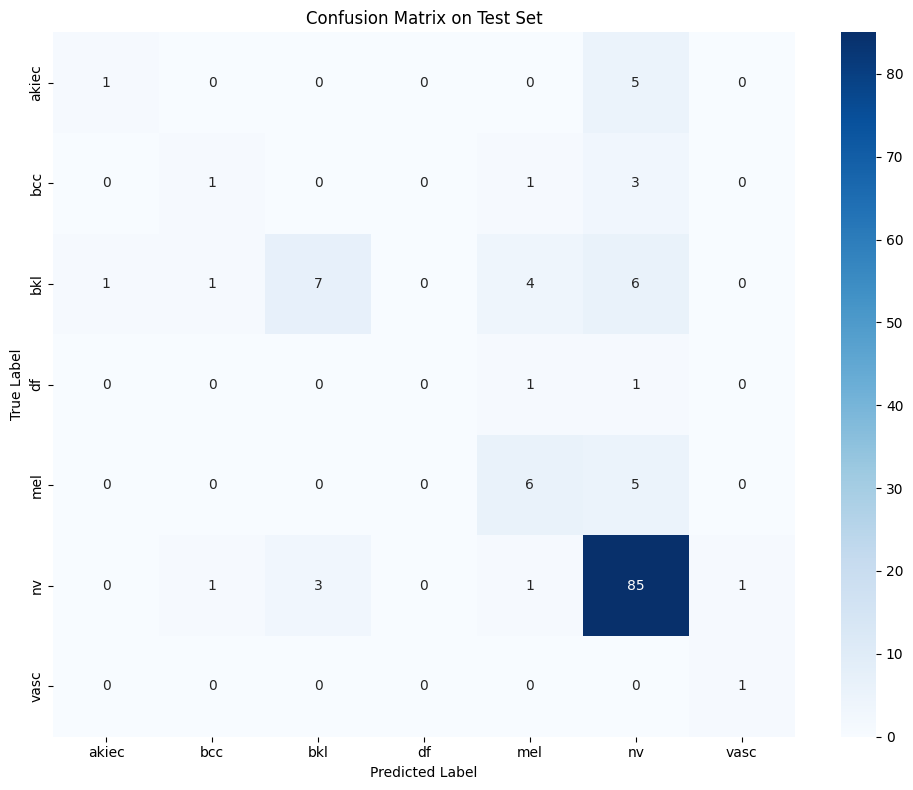

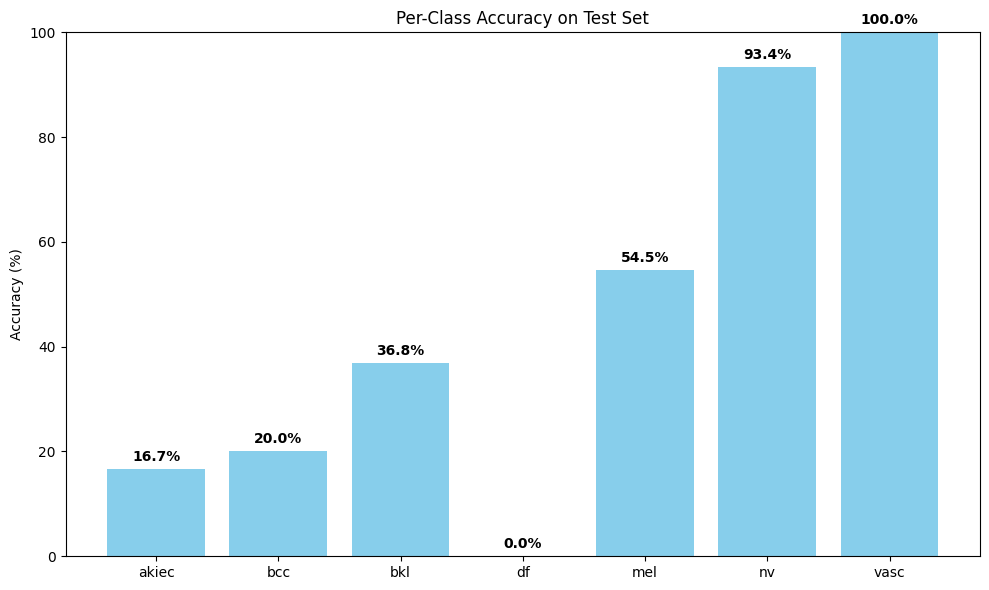


Random Test Samples with Model Predictions:


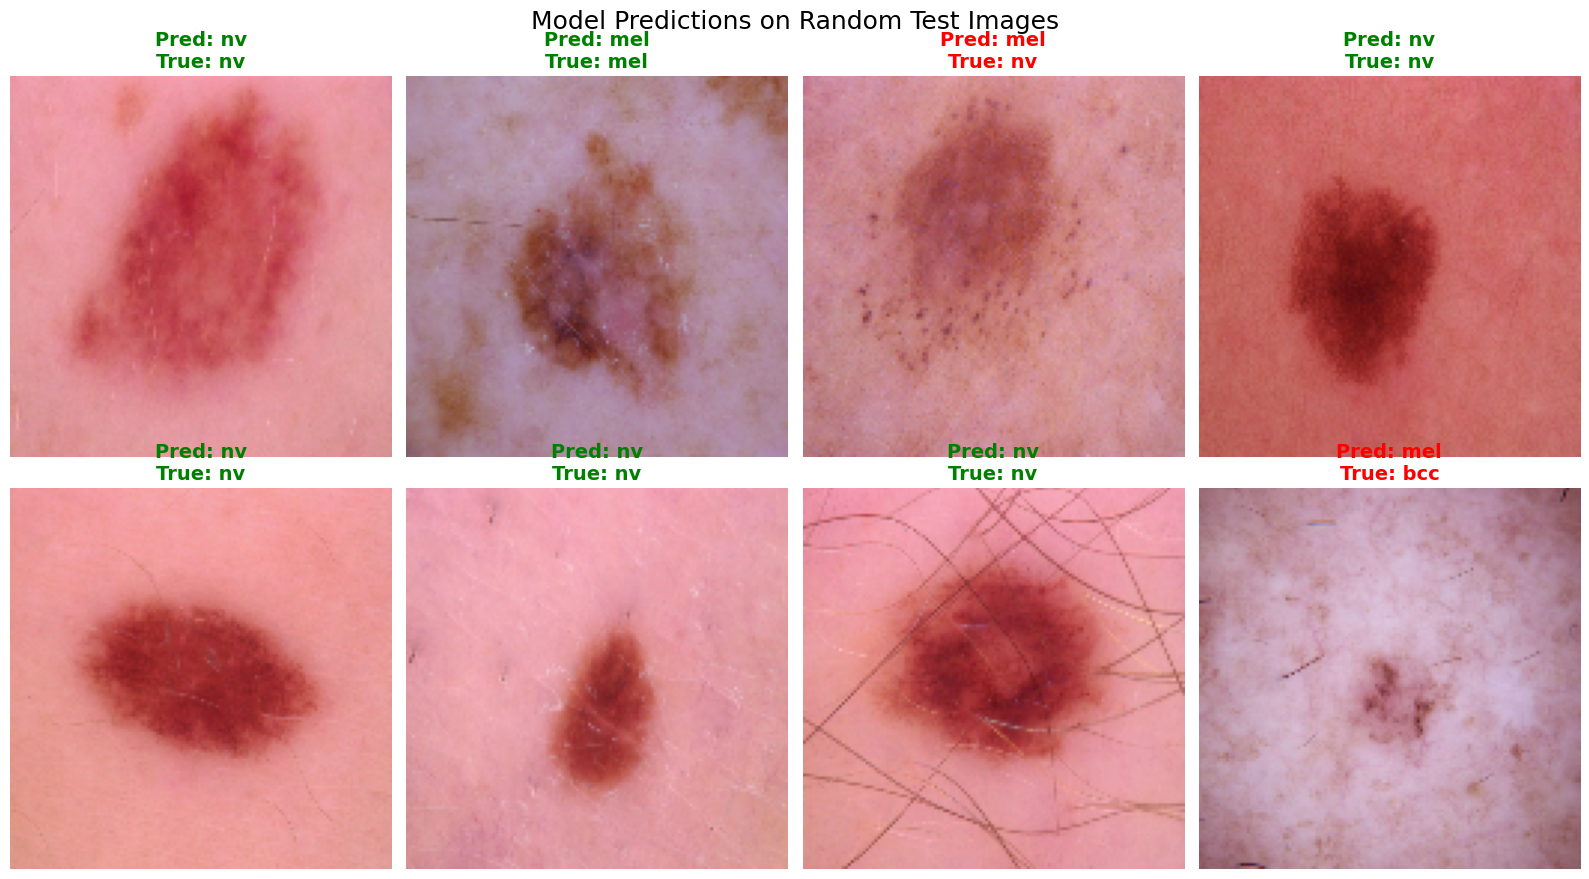


Evaluation completed successfully!


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

print("FINAL EVALUATION ON TEST SET")
print("=" * 50)

# Load the best saved model
model.load_state_dict(torch.load('/content/drive/MyDrive/HAM10000_dataset/best_model.pth', map_location=device))
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []
all_probs = []  # for potential future use

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall Test Accuracy
test_acc = 100. * (all_preds == all_labels).sum() / len(all_labels)
print(f"Overall Test Accuracy: {test_acc:.2f}%")

# Per-class accuracy and classification report
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Per-class accuracy visualization
per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, per_class_acc, color='skyblue')
plt.title('Per-Class Accuracy on Test Set')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'{per_class_acc[i]:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# Display 8 random test samples with predictions
print("\nRandom Test Samples with Model Predictions:")
num_samples = 8
indices = random.sample(range(len(test_dataset)), num_samples)

fig, axes = plt.subplots(2, 4, figsize=(16, 9))
axes = axes.ravel()

for i, idx in enumerate(indices):
    image, true_label = test_dataset[idx]

    # Model prediction
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        _, pred = output.max(1)
        pred_label = pred.item()

    pred_class = class_names[pred_label]
    true_class = class_names[true_label]

    # Denormalize image for display
    img_display = image.permute(1, 2, 0).cpu().numpy()
    img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_display = np.clip(img_display, 0, 1)

    axes[i].imshow(img_display)
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f"Pred: {pred_class}\nTrue: {true_class}",
                      fontsize=14, color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle("Model Predictions on Random Test Images", fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

print("\nEvaluation completed successfully!")